In [1]:
import os
from pathlib import Path
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# loading python packages and files from repo root
if Path(os.getcwd()).name != "SSL4EO_base":
    os.chdir("..")
from data import constants
from data.constants import MMEARTH_DIR, input_size
from data import MMEarthDataset, create_MMEearth_args
from methods import transforms

/work/project/cenv/ssl4eo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# initialize dataset
modalities = constants.INP_MODALITIES
split = "train"
args = create_MMEearth_args(MMEARTH_DIR, modalities, {"biome": constants.MODALITIES_FULL["biome"]})

dataset = MMEarthDataset(args, split=split)

## Visual Inspection of Samples

In [4]:
# choosing a random sample
data = dataset[42]

In [5]:
# our input modality is sentinel 2
s2 = data["sentinel2"]
print(s2.shape)

# other information exists, such as biome information
biome = data["biome"]
print(biome)

(12, 128, 128)
11


In [11]:
# helper function to show images
def display_s2_image(s2, ax=None):
    if ax is None:
        ax = plt
    rgb_s2 = s2[[3, 2, 1]]
    # normalize for showing
    rgb_min = rgb_s2.min(axis=(1, 2), keepdims=True)
    rgb_max = rgb_s2.max(axis=(1, 2), keepdims=True)
    rgb_s2 = (rgb_s2 - rgb_min) / (rgb_max - rgb_min)
    ax.imshow(np.moveaxis(rgb_s2, 0, -1))

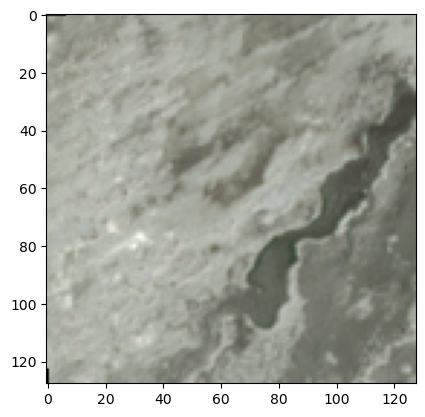

In [13]:
display_s2_image(s2)

### Applying Augmentations

In [14]:
# init transforms. Note that these are of type torch.nn.Module
transform_list = [
    transforms.BarlowTwinsTransform(
        transforms.BarlowTwinsView1Transform(input_size=input_size),
        transforms.BarlowTwinsView2Transform(input_size=input_size),
    ),
    transforms.SimCLRTransform(input_size=input_size),
    transforms.BYOLTransform(
        transforms.BYOLView1Transform(input_size=input_size),
        transforms.BYOLView2Transform(input_size=input_size),
    ),
    transforms.VICRegTransform(input_size=input_size),
    transforms.MAETransform(input_size=input_size),
]

### Showing Single Transform

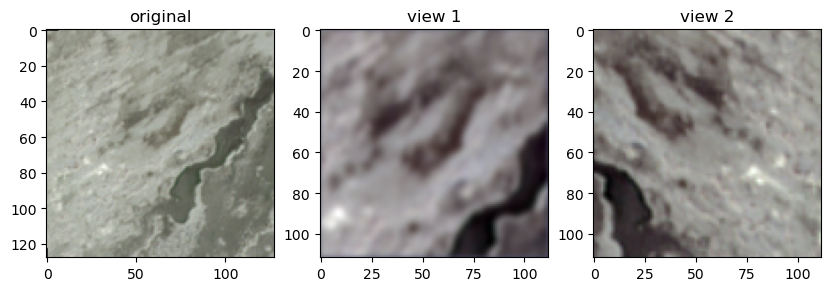

In [15]:
# choosing a random sample
data = dataset[42]

# choosing transform
transform = transform_list[0]

# just a single image
f, ax = plt.subplots(1, 3, figsize=(10, 10)) # 3 images: original, view 1, and view 2 

# plot original
display_s2_image(s2, ax=ax[0])
ax[0].set_title("original")

# getting ready for transform by reading as tensor and adding batch dimension
s2_torch = torch.from_numpy(s2).unsqueeze(0)

# apply tranform
s2_transformed = transform(s2_torch)

# back to numpy
view1 = s2_transformed[0] # first view
view2 = s2_transformed[1] # second view
view1 = view1[0].numpy() # remove batch dim and convert to numpy
view2 = view2[0].numpy() # remove batch dim and convert to numpy

# plot transform
display_s2_image(view1, ax=ax[1])
ax[1].set_title("view 1")
display_s2_image(view2, ax=ax[2])
ax[2].set_title("view 2");


### Showing All Transforms

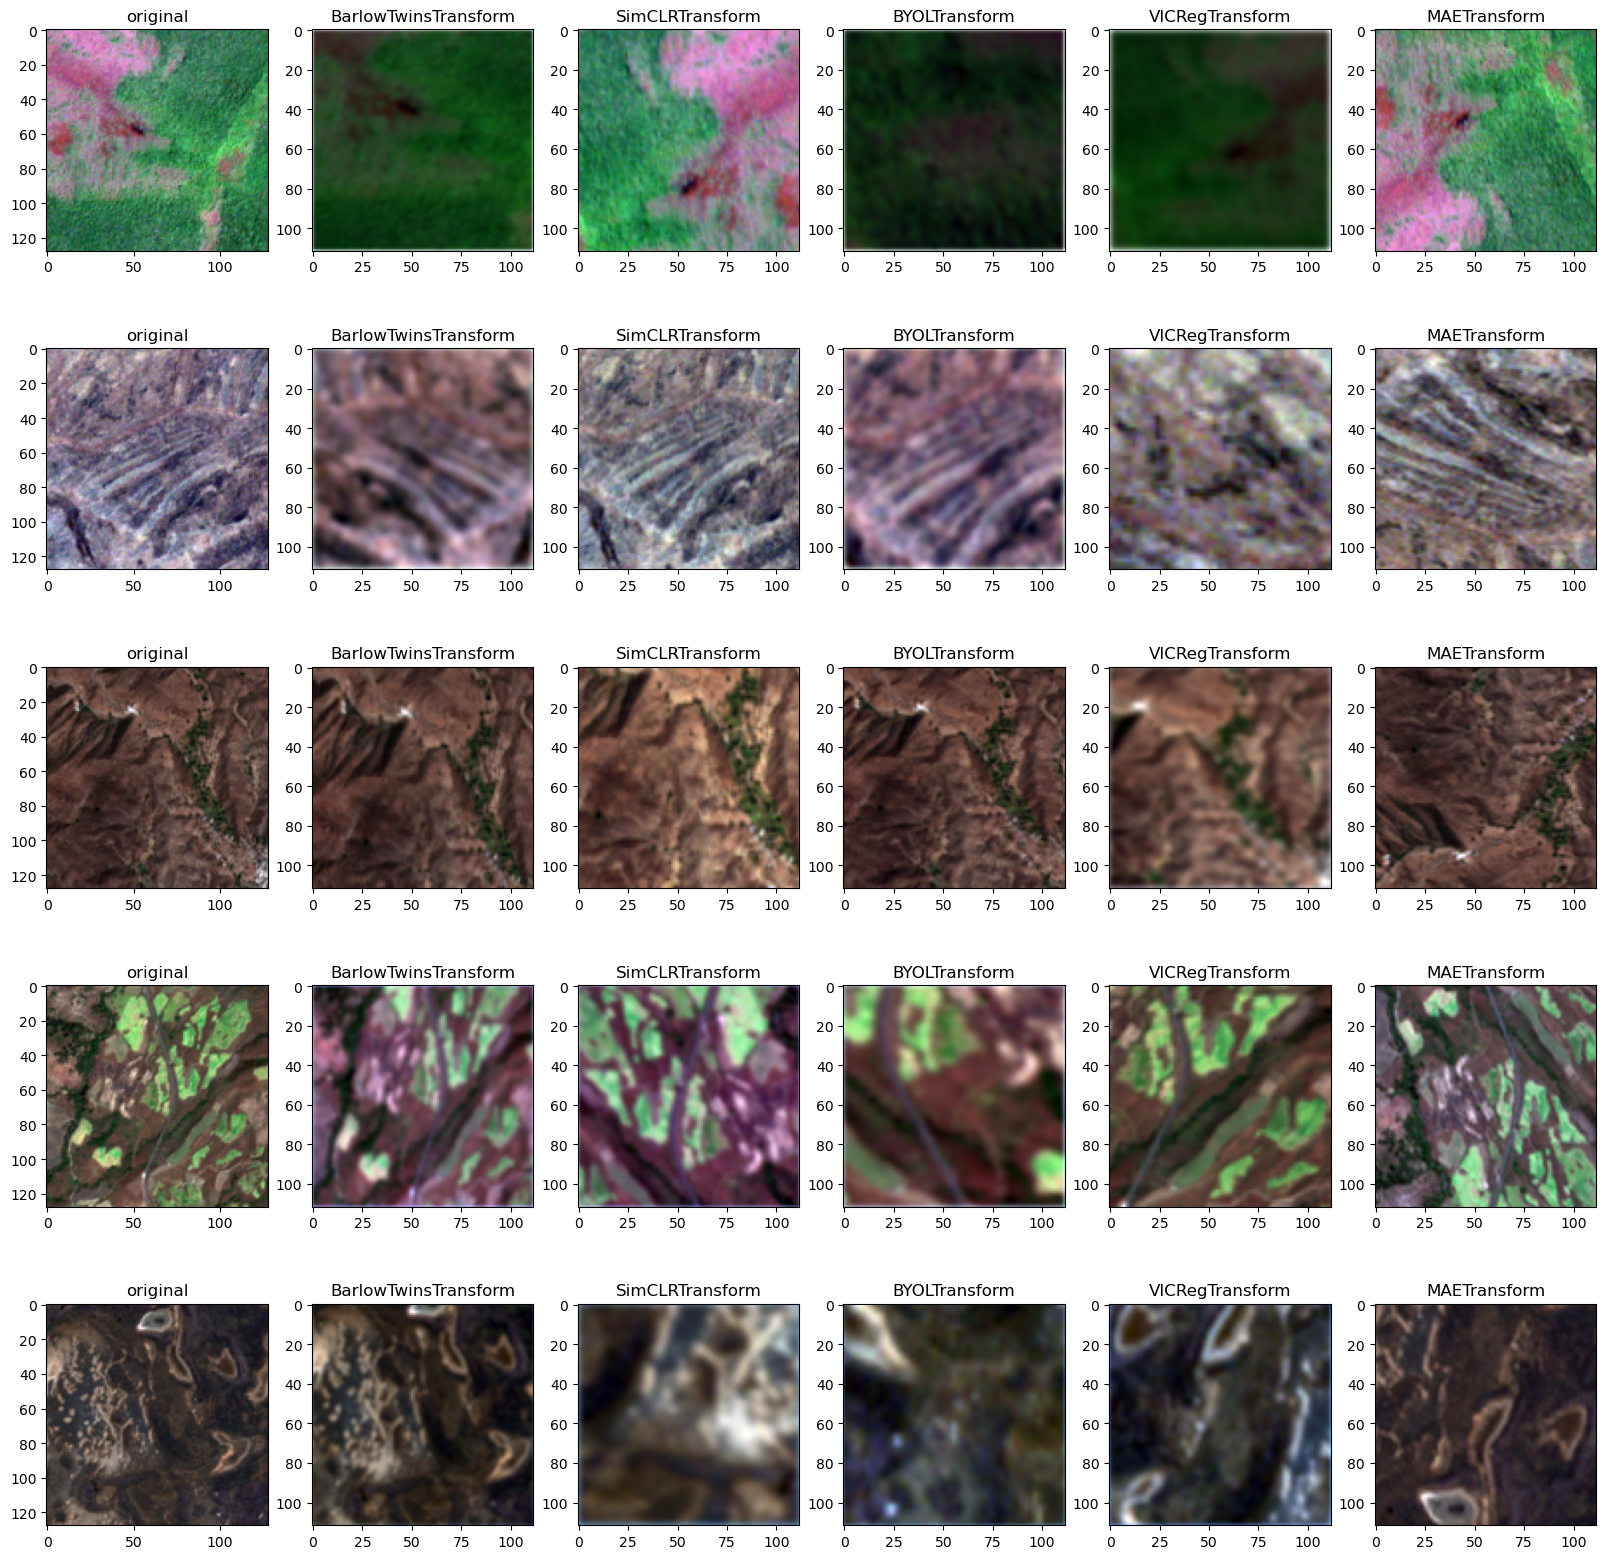

In [16]:
num_samples = 5
f, ax = plt.subplots(num_samples, 1 + len(transform_list), figsize=(20, 20))
for i in range(num_samples):
    # get random image
    idx = np.random.randint(len(dataset))
    # load data
    data = dataset[idx]
    s2 = data["sentinel2"]

    # plot original
    display_s2_image(s2, ax=ax[i, 0])
    ax[i, 0].set_title("original")
    
    # getting ready for transform by reading as tensor and adding batch dimension
    s2_torch = torch.from_numpy(s2).unsqueeze(0)
    
    for j, transform in enumerate(transform_list):
        s2_transformed = transform(s2_torch)
        # back to numpy
        s2_transformed = s2_transformed[0] # only first view
        s2_transformed = s2_transformed[0].numpy() # remove batch dim and convert to numpy

        # plot transform
        display_s2_image(s2_transformed, ax=ax[i, 1 + j])
        name = transform.__class__.__name__.split(".")[-1]
        ax[i, 1 + j].set_title(name)